In [2]:
import os 
import sys 

sys.path.append('/mnt/data/robers/projects/TimeXer')
os.chdir('/mnt/data/robers/projects/TimeXer')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


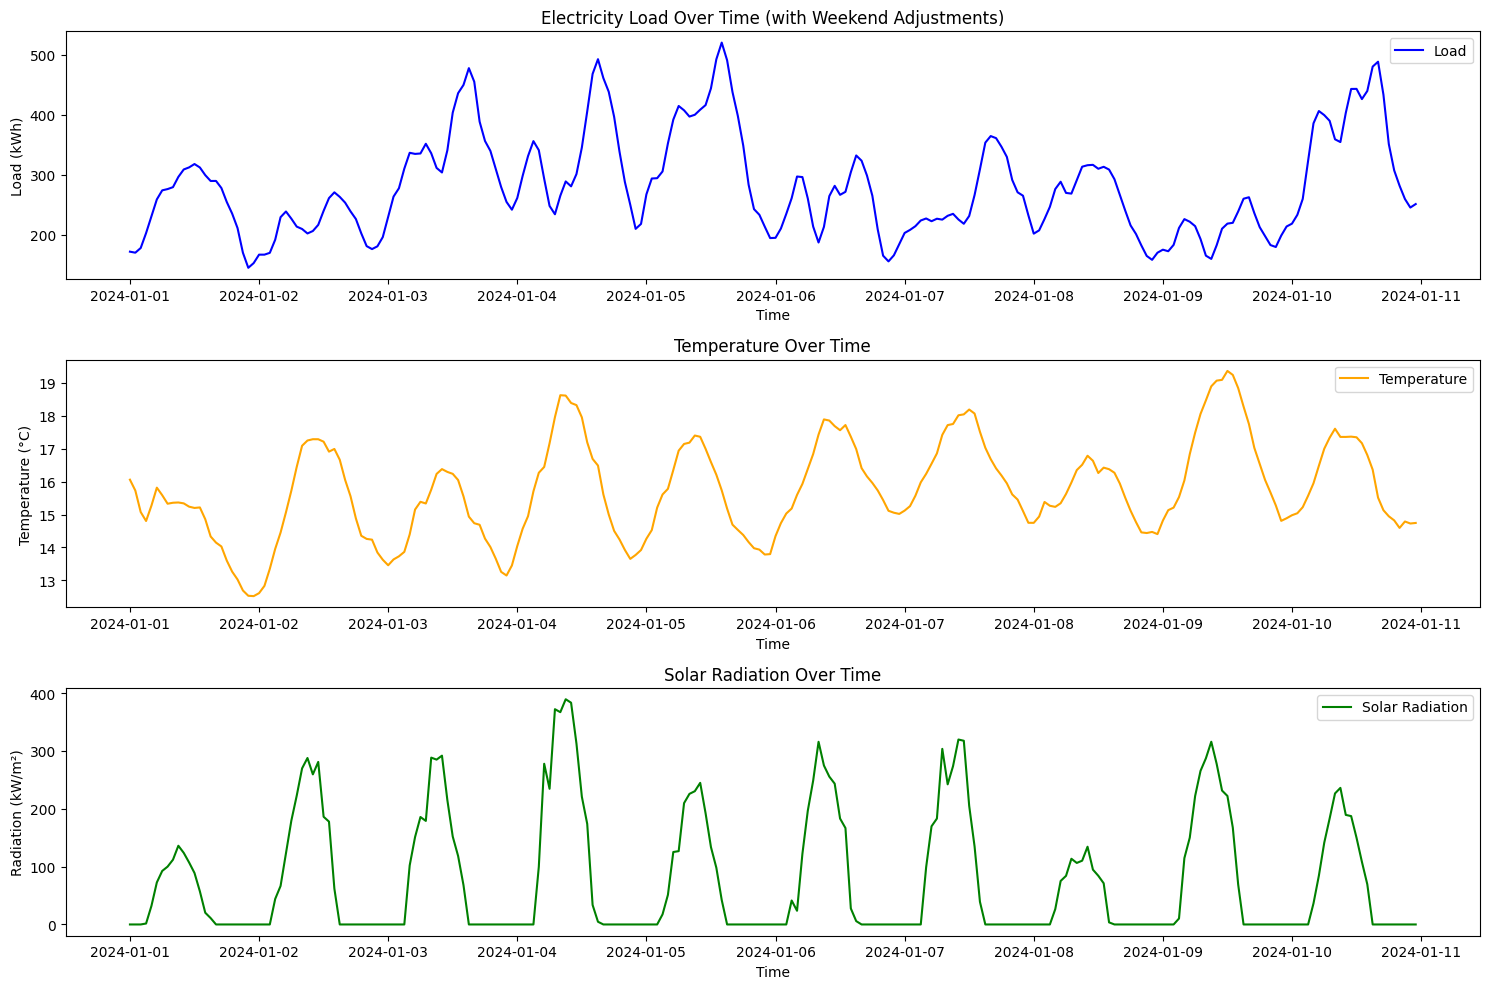

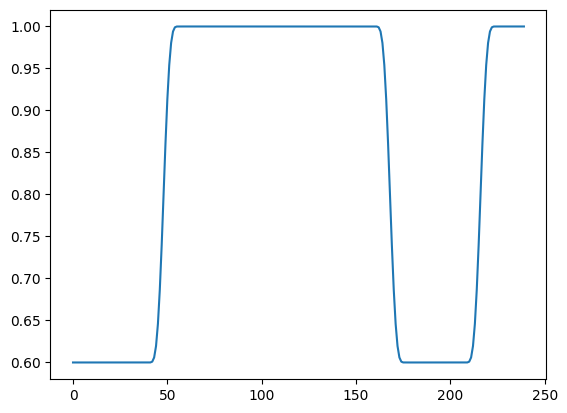

In [5]:
# autoreload 
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.src.dataset_functions import plot_time_series, adjust_weekend_load, smoothen, generate_temperature_profile, create_daily_scales, adjust_bool_day
# Parameters
# np.random.seed(42)
hours = 240  # One year of hourly data
time = np.arange(hours)
time_pd = pd.date_range('2024-01-01', periods=hours, freq='H')
noise = .9
daily_scales = create_daily_scales(time_pd, 0.8)
daily_scales_2 = create_daily_scales(time_pd, 1.0)

temperature = generate_temperature_profile(time=time, noise=noise, daily_scales=daily_scales)
solar_radiation = np.clip(500 * np.sin(2 * np.pi * time / 24 - np.pi/4) + noise * np.random.normal(0, 50, hours), 0, None) * daily_scales
# Base Load
base_load = 500 + 200 * np.sin(2 * np.pi * time / 24 - np.pi/3) + 100 * np.cos(2 * np.pi * time / 8760)

# Create DataFrame
df = pd.DataFrame({
    'time': pd.date_range('2024-01-01', periods=hours, freq='H'),
    'temperature': temperature,
    'solar_radiation': solar_radiation,
})

df['temperature'] = smoothen(df, 'temperature', rolling_window=40)['temperature']

load = base_load - 10 * df['temperature'] - 1. * df['solar_radiation'] + noise * np.random.normal(0, 50, hours)
df['load'] = adjust_weekend_load(load, df['time'], 12,24,10,22)
df['load'], bool_scales, boold_days = adjust_bool_day(df['load'], daily_scales_2, 16)
df['load'] = smoothen(df, 'load', rolling_window=10)['load']
df['bool_day'] = boold_days
plot_time_series(df)

plt.plot(bool_scales)


In [3]:
df.columns

Index(['time', 'temperature', 'solar_radiation', 'load', 'bool_day'], dtype='object')

In [4]:
from utils.src.dataset_functions import export_to_csv

export_to_csv(df, '/home/robers/projects/TimeXer/dataset/custom/dataset2.csv')